In [212]:
'''
5.3.2 GRU - PyTorch (sin波)
'''

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optimizers
from callbacks import EarlyStopping


class RNN(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.l1 = nn.GRU(1, hidden_dim,
                         batch_first=True)
        self.l2 = nn.Linear(hidden_dim, 1)

        nn.init.xavier_normal_(self.l1.weight_ih_l0)
        nn.init.orthogonal_(self.l1.weight_hh_l0)

    def forward(self, x):
        h, _ = self.l1(x)
        y = self.l2(h[:, -1])
        return y


In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("co2.csv")
f = df['CO2']

In [214]:
np.random.seed(123)
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [215]:
maxlen = 200
remove = len(co2_pre)%maxlen
length_of_sequences = len(co2_pre)-remove

x = []
t = []

times = []
for i in range(len(f)):
    times.append(i)

for i in range(length_of_sequences - maxlen):
    x.append(f[i:i+maxlen])
    t.append(f[i+maxlen])

x = np.array(x).reshape(-1, maxlen, 1)
t = np.array(t).reshape(-1, 1)

In [216]:
x_train, x_val, t_train, t_val = \
    train_test_split(x, t, test_size=0.2, shuffle=False)

'''
2. モデルの構築
'''
# model = RNN(50).to(device)
model = RNN(100).to(device)

'''
3. モデルの学習
'''
criterion = nn.MSELoss(reduction='mean')
optimizer = optimizers.Adam(model.parameters(),
                            lr=0.001,
                            betas=(0.9, 0.999), amsgrad=True)

def compute_loss(t, y):
    return criterion(y, t)

def train_step(x, t):
    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    model.train()
    preds = model(x)
    loss = compute_loss(t, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, preds

def val_step(x, t):
    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    model.eval()
    preds = model(x)
    loss = criterion(preds, t)

    return loss, preds

In [217]:
epochs = 2000
batch_size = 100
n_batches_train = x_train.shape[0] // batch_size + 1
n_batches_val = x_val.shape[0] // batch_size + 1
hist = {'loss': [], 'val_loss': []}
es = EarlyStopping(patience=10, verbose=1)

for epoch in range(epochs):
    train_loss = 0.
    val_loss = 0.
    x_, t_ = shuffle(x_train, t_train)

    for batch in range(n_batches_train):
        start = batch * batch_size
        end = start + batch_size
        loss, _ = train_step(x_[start:end], t_[start:end])
        train_loss += loss.item()

    for batch in range(n_batches_val):
        start = batch * batch_size
        end = start + batch_size
        loss, _ = val_step(x_val[start:end], t_val[start:end])
        val_loss += loss.item()

    train_loss /= n_batches_train
    val_loss /= n_batches_val

    hist['loss'].append(train_loss)
    hist['val_loss'].append(val_loss)

    print('epoch: {}, loss: {:.3}, val_loss: {:.3f}'.format(
        epoch+1,
        train_loss,
        val_loss
    ))

    if es(val_loss):
        break

epoch: 1, loss: 1.39e+05, val_loss: 159990.261
epoch: 2, loss: 1.38e+05, val_loss: 158301.011
epoch: 3, loss: 1.36e+05, val_loss: 156884.748
epoch: 4, loss: 1.35e+05, val_loss: 155498.587
epoch: 5, loss: 1.34e+05, val_loss: 154054.146
epoch: 6, loss: 1.32e+05, val_loss: 152614.850
epoch: 7, loss: 1.31e+05, val_loss: 151165.478
epoch: 8, loss: 1.3e+05, val_loss: 149737.311
epoch: 9, loss: 1.28e+05, val_loss: 148333.533
epoch: 10, loss: 1.27e+05, val_loss: 146947.503
epoch: 11, loss: 1.26e+05, val_loss: 145577.323
epoch: 12, loss: 1.25e+05, val_loss: 144221.461
epoch: 13, loss: 1.23e+05, val_loss: 142878.743
epoch: 14, loss: 1.22e+05, val_loss: 141547.838
epoch: 15, loss: 1.21e+05, val_loss: 140227.770
epoch: 16, loss: 1.2e+05, val_loss: 138919.165
epoch: 17, loss: 1.18e+05, val_loss: 137621.108
epoch: 18, loss: 1.17e+05, val_loss: 136333.147
epoch: 19, loss: 1.16e+05, val_loss: 135055.308
epoch: 20, loss: 1.15e+05, val_loss: 133786.719
epoch: 21, loss: 1.14e+05, val_loss: 132528.142
epo

In [218]:
torch.save(model.state_dict(), './gru.pth')

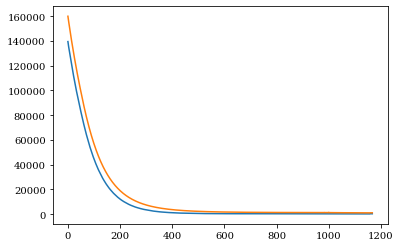

In [219]:
loss = hist['loss']
val_loss = hist['val_loss']
plt.plot(loss)
plt.plot(val_loss)

In [224]:
'''
4. モデルの評価
'''
model.eval()

# sin波の予測
#sin = toy_problem(T, ampl=0.)
gen = [None for i in range(maxlen)]

z = x[:1]

for i in range(length_of_sequences - maxlen):
    z_ = torch.Tensor(z[-1:]).to(device)
    preds = model(z_).data.cpu().numpy()
    z = np.append(z, preds)[1:]
    z = z.reshape(-1, maxlen, 1)
    gen.append(preds[0, 0])
    # zs = zs+z.reshape(maxlen,1).flatten().tolist()


3459
3400


<Figure size 432x288 with 0 Axes>

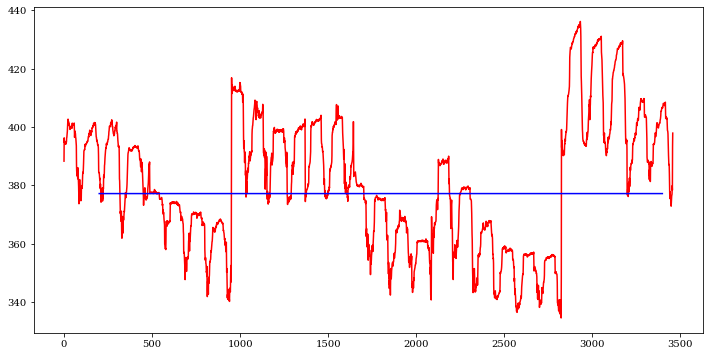

In [225]:
# 予測値を可視化
fig = plt.figure()
from matplotlib.pyplot import figure
figure(figsize=(12, 6))

plt.plot(f, color='red')
plt.plot(gen, color='blue')
print(len(f))
print(len(gen))

In [238]:
print(f.mean())
print(pd.DataFrame(gen).mean())

380.89783353418244
0    377.184326
dtype: float64


# 結果の解釈

In [ ]:
学習の結果定常地に収束し、学習